<a href="https://colab.research.google.com/github/tetianasokolova/computer-vision-project/blob/main/CVDL_Project_Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Task 3 of Tetiana Sokolova
**Link to GitHub**: https://github.com/tetianasokolova/computer-vision-project.git

## Instructions
**Оптимізація гіперпараметрів моделі нейронної мережі**
### 1 Ручна оптимізація
Запустіть кілька експериментів з різними налаштуваннями гіперпараметрів:
- Виберіть мінімум три варіанти для кожного з золотих параметрів
(наприклад, для learning rate спробуйте 0.001, 0.0001, 0.01).
- Змінюйте кількість нейронів у повнозв'язаних шарах та кількість
згорткових шарів.

### 2 Автоматизована оптимізація
- Використайте бібліотеки, такі як GridSearchCV, RandomizedSearchCV
або Optuna для автоматизованого підбору гіперпараметрів.
- Налаштуйте гіпер параметри крос-валідації, щоб оцінити продуктивність
моделі при різних конфігураціях.

### 3 Оцінка продуктивності моделі
3.1 Запустіть модель з оптимізованими гіперпараметрами:
- Використайте кращі знайдені значення для тренування моделі.
3.2 Оцінка результатів:
- Оцініть модель, використовуючи попередньо визначені метрики
(точність, F1-score, матриця плутанини).
3.3 Порівняйте результати з моделью, побудованою попередньо, для
визначення зміни значення функції втрат від зміни гіперпараметрів.


### 4 Візуалізація результатів
4.1 Проведіть візуалізацію:
- Побудуйте графіки, що показують зміни точності та втрат для різних
варіантів навчання.
- Створіть графік для демонстрації залежності між різними значеннями
гіперпараметрів та точністю моделів.

In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.utils import make_grid
from collections import defaultdict

## Load the dataset Animals-10
Connect to Google Drive account.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip in Colab's temporary storage
zip_path = "/content/drive/MyDrive/NaUKMAProgramming/DeepLearning/Data/Animals-10.zip"
data_path = "/content/raw-img"  # Extract in Colab's temporary storage

if not os.path.exists(data_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content/")  # Extract directly to /content/

In [ ]:
# Load the data
data = datasets.ImageFolder(root=data_path)

There are 26,179 images in Animal-10 dataset.

In [ ]:
len(data)

26179

Check classes of the data. We see that there are 10 classes of animals.

In [ ]:
# Check class-to-index mapping
data.classes

['cane',
 'cavallo',
 'elefante',
 'farfalla',
 'gallina',
 'gatto',
 'mucca',
 'pecora',
 'ragno',
 'scoiattolo']

Translate classes names from Italian to English using dictionary from Python file in the data archiv.

In [ ]:
translate = {"cane": "dog",
             "cavallo": "horse",
             "elefante": "elephant",
             "farfalla": "butterfly",
             "gallina": "chicken",
             "gatto": "cat",
             "mucca": "cow",
             "pecora": "sheep",
             "ragno": "spider",
             "scoiattolo": "squirrel"}

In [ ]:
data.classes = [translate.get(name, name) for name in data.classes]
data.class_to_idx = {name: idx for idx, name in enumerate(data.classes)}

In [ ]:
data.classes

['dog',
 'horse',
 'elephant',
 'butterfly',
 'chicken',
 'cat',
 'cow',
 'sheep',
 'spider',
 'squirrel']

In [ ]:
!pip install basic_image_eda

Explore the dataset with BasicImageEDA library

In [ ]:
from basic_image_eda import BasicImageEDA

# Create an instance of BasicImageEDA and explore the dataset
eda = BasicImageEDA()
eda.explore(data_path)


found 26179 images.
Using 2 threads. (max:2)



100%|██████████| 26179/26179 [02:02<00:00, 214.51it/s]


*--------------------------------------------------------------------------------------*
number of images                         |  26179

dtype                                    |  uint8
channels                                 |  [1, 3, 4]
extensions                               |  ['jpeg', 'png', 'jpg']

min height                               |  57
max height                               |  6000
mean height                              |  252.63016157989227
median height                            |  225

min width                                |  60
max width                                |  6720
mean width                               |  320.0388097329921
median width                             |  300

mean height/width ratio                  |  0.7893735193886681
median height/width ratio                |  0.75
recommended input size(by mean)          |  [256 320] (h x w, multiples of 8)
recommended input size(by mean)          |  [256 320] (h x w, multiples of 16)
rec

{'dtype': 'uint8',
 'channels': [1, 3, 4],
 'extensions': ['jpeg', 'png', 'jpg'],
 'min_h': 57,
 'max_h': 6000,
 'mean_h': 252.63016157989227,
 'median_h': 225,
 'min_w': 60,
 'max_w': 6720,
 'mean_w': 320.0388097329921,
 'median_w': 300,
 'mean_hw_ratio': 0.7893735193886681,
 'median_hw_ratio': 0.75,
 'rec_hw_size_8': array([256, 320]),
 'rec_hw_size_16': array([256, 320]),
 'rec_hw_size_32': array([256, 320]),
 'mean': array([0.5177272, 0.500307 , 0.4125527], dtype=float32),
 'std': array([0.27112892, 0.26629838, 0.2833791 ], dtype=float32)}

## Transform data
Set up data transformations for train, validation and test datasets. Add data augmentation to data transformation for train. We use the same data transformations for validation and test.

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.RandomHorizontalFlip(),   # Flip the image horizontally with probability 0.5
    transforms.RandomRotation(20),   # Rotate the image randomly by up to 10 degrees
    transforms.ToTensor(),  # Scale pixel values from [0, 255] to [0, 1] and flip image format from H x W x C to C x H x W
    transforms.Normalize((0.5177272, 0.500307, 0.4125527), (0.27112892, 0.26629838, 0.2833791))  # Mean value for channels, sgd for channels; scale from [0,1] to [-1,1]
])

In [ ]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.RandomHorizontalFlip(),   # Flip the image horizontally with probability 0.5
    transforms.RandomRotation(20),   # Rotate the image randomly by up to 10 degrees
    transforms.ToTensor(),  # Scale pixel values from [0, 255] to [0, 1] and flip image format from H x W x C to C x H x W
    transforms.Normalize((0.5177272, 0.500307, 0.4125527), (0.27112892, 0.26629838, 0.2833791))  # Mean value for channels, sgd for channels; scale from [0,1] to [-1,1]
])

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),  # Scale pixel values from [0, 255] to [0, 1] and flip image format from H x W x C to C x H x W
    transforms.Normalize((0.5177272, 0.500307, 0.4125527), (0.27112892, 0.26629838, 0.2833791))  # Mean value for channels, sgd for channels; scale from [0,1] to [-1,1]
])

## Split data into train, validation and test
65% - train data, 15% - validation data and 20% - test data.

In [ ]:
train_ds, val_ds, test_ds = random_split(data, [0.65, 0.15, 0.2])

Create a class TransformedSubset to apply separate transformation to each subset after split.

In [ ]:
class TransformedSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

Apply data transformations to each subset.

In [ ]:
train_ds = TransformedSubset(train_ds, transform=train_transform)
val_ds = TransformedSubset(val_ds, transform=val_transform)
test_ds = TransformedSubset(test_ds, transform=test_transform)

Check size of each dataset after split.

In [ ]:
len(train_ds), len(val_ds), len(test_ds)

(17017, 3927, 5235)

Make dataloaders for train, validaton and test data to simplify loading process by batches.

In [ ]:
batch_size = 32

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
!pip install ann_visualizer

  Preparing metadata (setup.py) ... done
  Created wheel for ann_visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4169 sha256=1ee056a0813667b68487711c7e355196370d79b19a8f13e05edb4c4b57758f42
  Stored in directory: /root/.cache/pip/wheels/28/4a/ad/e82da1aad2994e42bf0f4b1d403fdd8a64dfc38ae2c8a5daa4
Successfully built ann_visualizer


In [ ]:
from ann_visualizer.visualize import ann_viz
from torchsummary import summary

## Define CNN architecture

Create a model with 5 convolutional layers followed by 2 fully-connected layers and output layer. We use 5x5 filter for the first layer and 3x3 filters for other convolutional layers, with padding to preserve the dimension of the picture. As activation function ReLU is used and max pooling is added. Add batch normalization to convolutional layers and dropout to fully-connected layers.

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2) # 32x224x224
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 32x112x112

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # 64x112x122
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64x56x56

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1) # 128x56x56
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 128x28x28

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1) # 256x28x28
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2) # 256x14x14

        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1) # 512x14x14
        self.bn5 = nn.BatchNorm2d(512)
        self.relu5 = nn.ReLU()
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2) # 512x7x7

        # Fully connected layers
        self.fc1 = nn.Linear(512*7*7, 512)
        self.dropout1 = nn.Dropout(0.2)
        self.relu5 = nn.ReLU()

        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.2)
        self.relu6 = nn.ReLU()

        self.fc3 = nn.Linear(256, 10)  # Output layer (logits)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.maxpool1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu3(out)
        out = self.maxpool3(out)

        out = self.conv4(out)
        out = self.bn4(out)
        out = self.relu4(out)
        out = self.maxpool4(out)

        out = self.conv5(out)
        out = self.bn5(out)
        out = self.relu5(out)
        out = self.maxpool5(out)

        out = out.view(out.size(0), -1)  # Flatten
        out = self.fc1(out)
        out = self.dropout1(out)
        out = self.relu5(out)

        out = self.fc2(out)
        out = self.dropout2(out)
        out = self.relu6(out)

        out = self.fc3(out)
        return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

## Train the model

### Manual Model Optimizaation

In [ ]:
# Define different learning rates to test
learning_rates = [0.01, 0.001, 0.0001]

# Dictionary to store results for each learning rate
results = {}

# Fixed hyperparameters
epochs = 10  # Reduced for quick testing
batch_size = 32

# Function to evaluate mode
def evaluate_model(model, dataloader):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        val_loss = total_loss / len(dataloader)
        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        return val_loss, accuracy, f1

# Train the model
for lr in learning_rates:
    print(f"\n=== Training with learning rate: {lr} ===\n")

    # Initialize model and optimizer
    model = CNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Lists to store metrics
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_f1s, val_f1s = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        all_preds, all_labels = [], []

        for images, labels in train_dl:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_dl)
        train_accuracy = accuracy_score(all_labels, all_preds)
        train_f1 = f1_score(all_labels, all_preds, average='weighted')

        val_loss, val_accuracy, val_f1 = evaluate_model(model, val_dl)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Train F1: {train_f1:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val F1: {val_f1:.4f}")

    # Store results for this learning rate
    results[lr] = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies,
        'train_f1': train_f1s,
        'val_f1': val_f1s,
        'final_val_accuracy': val_accuracy,
        'final_val_f1': val_f1
    }


=== Training with learning rate: 0.01 ===

Epoch 1/10: Train Loss: 3.3511, Train Acc: 0.1846, Train F1: 0.1087 | Val Loss: 2.2067, Val Acc: 0.1772, Val F1: 0.0537
Epoch 2/10: Train Loss: 2.2084, Train Acc: 0.1879, Train F1: 0.1018 | Val Loss: 2.2076, Val Acc: 0.1770, Val F1: 0.0532
Epoch 3/10: Train Loss: 2.2087, Train Acc: 0.1848, Train F1: 0.1003 | Val Loss: 2.2074, Val Acc: 0.1770, Val F1: 0.0532
Epoch 4/10: Train Loss: 2.2085, Train Acc: 0.1850, Train F1: 0.1005 | Val Loss: 2.2068, Val Acc: 0.1770, Val F1: 0.0532
Epoch 5/10: Train Loss: 2.2106, Train Acc: 0.1851, Train F1: 0.1007 | Val Loss: 2.2086, Val Acc: 0.1770, Val F1: 0.0532
Epoch 6/10: Train Loss: 2.2082, Train Acc: 0.1844, Train F1: 0.0998 | Val Loss: 2.2082, Val Acc: 0.1887, Val F1: 0.0599
Epoch 7/10: Train Loss: 2.2080, Train Acc: 0.1861, Train F1: 0.0992 | Val Loss: 2.2070, Val Acc: 0.1770, Val F1: 0.0532
Epoch 8/10: Train Loss: 2.2081, Train Acc: 0.1869, Train F1: 0.1015 | Val Loss: 2.2073, Val Acc: 0.1887, Val F1: 0.0

In [ ]:
# Find the best learning rate
best_lr = max(results.items(), key=lambda x: x[1]['final_val_f1'])[0]
print(f"\nBest learning rate: {best_lr} with validation accuracy: {results[best_lr]['final_val_accuracy']:.4f}")


Best learning rate: 0.0001 with validation accuracy: 0.7454


### Visualisation of the results

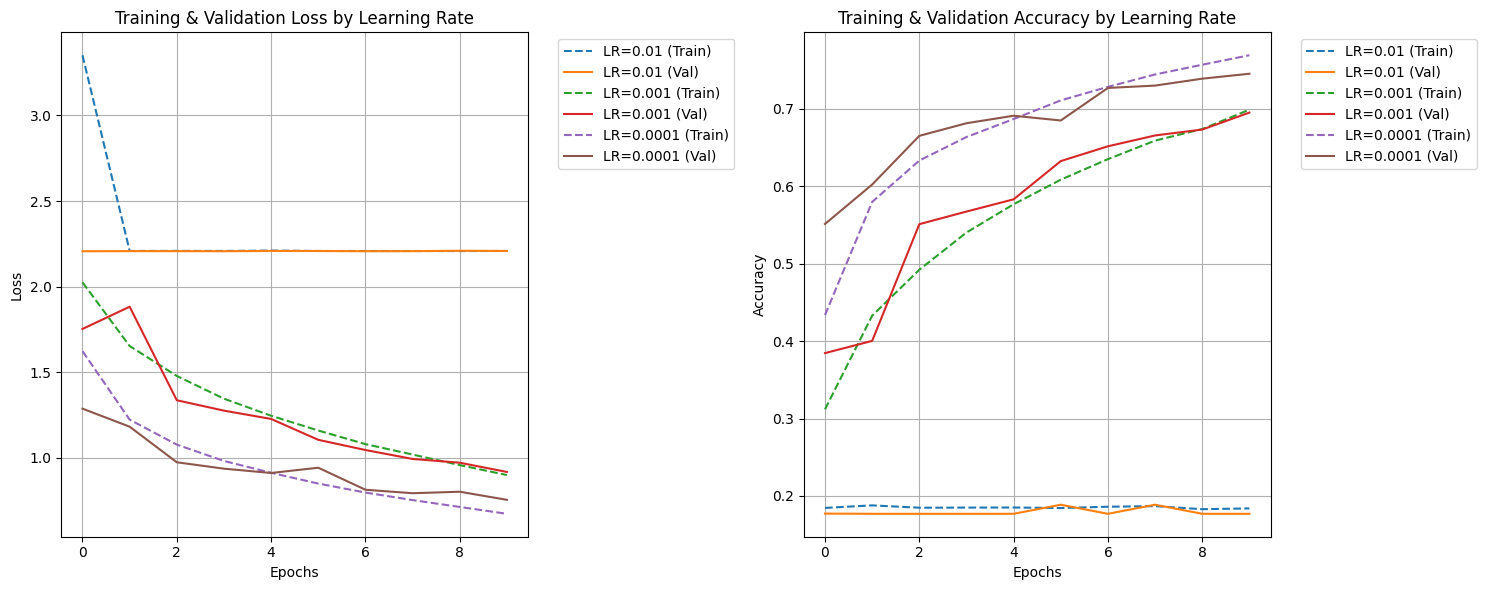

In [ ]:
# Set up the figure
plt.figure(figsize=(15, 6))

# Training and Validation Losses for all LRs
plt.subplot(1, 2, 1)
for lr, data in results.items():
    plt.plot(data['train_loss'], '--', label=f'LR={lr} (Train)')
    plt.plot(data['val_loss'], '-', label=f'LR={lr} (Val)')

plt.title('Training & Validation Loss by Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Training and Validation Accuracies for all LRs
plt.subplot(1, 2, 2)
for lr, data in results.items():
    plt.plot(data['train_accuracy'], '--', label=f'LR={lr} (Train)')
    plt.plot(data['val_accuracy'], '-', label=f'LR={lr} (Val)')

plt.title('Training & Validation Accuracy by Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

--------

### Automated optimization

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 21.6 MB/s eta 0:00:00


In [ ]:
# Function to evaluate model
def evaluate_model(model, dataloader, loss_function):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation for efficiency
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)  # Use passed loss function
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())  # Convert tensors to numpy
            all_labels.extend(labels.cpu().numpy())

    # Compute loss, accuracy, and F1-score
    val_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return val_loss, accuracy, f1

In [ ]:
import optuna
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader

# Define objective function for Optuna
def objective(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    dropout_rate = trial.suggest_float('dropout', 0.1, 0.5)

    model = CNN().to(device)  # Ensure CNN() is defined
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()

    train_dl_opt = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl_opt = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    print(f"\n=== Training with learning rate: {lr:.6f}, batch size: {batch_size}, dropout: {dropout_rate:.2f} ===\n")

    for epoch in range(5):  # Limit to 5 epochs for efficiency
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        for images, labels in train_dl_opt:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_loss, val_acc, val_f1 = evaluate_model(model, val_dl_opt, loss_function)

        print(f"Epoch {epoch+1}/5: Train Loss: {train_loss / len(train_dl_opt):.4f}, "
              f"Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

    return val_f1  # Optimize based on F1-score

# Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)  # Limit trials for reasonable execution time

# Get best hyperparameters
best_params = study.best_params
print("\nBest Parameters:", best_params)

[I 2025-03-25 09:55:44,374] A new study created in memory with name: no-name-b235b13f-7540-4951-9540-ba1c98cbdc43



=== Training with learning rate: 0.000174, batch size: 16, dropout: 0.14 ===

Epoch 1/5: Train Loss: 1.6839, Train Acc: 0.4144 | Val Loss: 1.3614, Val Acc: 0.5190, Val F1: 0.4852
Epoch 2/5: Train Loss: 1.3169, Train Acc: 0.5455 | Val Loss: 1.1615, Val Acc: 0.5900, Val F1: 0.5826
Epoch 3/5: Train Loss: 1.1551, Train Acc: 0.6042 | Val Loss: 1.0547, Val Acc: 0.6450, Val F1: 0.6365
Epoch 4/5: Train Loss: 1.0414, Train Acc: 0.6407 | Val Loss: 1.0611, Val Acc: 0.6463, Val F1: 0.6425


[I 2025-03-25 10:06:01,347] Trial 0 finished with value: 0.694206433811057 and parameters: {'lr': 0.00017441617479647573, 'batch_size': 16, 'dropout': 0.14344290632454723}. Best is trial 0 with value: 0.694206433811057.


Epoch 5/5: Train Loss: 0.9660, Train Acc: 0.6700 | Val Loss: 0.8830, Val Acc: 0.6957, Val F1: 0.6942

=== Training with learning rate: 0.000078, batch size: 16, dropout: 0.29 ===

Epoch 1/5: Train Loss: 1.6635, Train Acc: 0.4228 | Val Loss: 1.3131, Val Acc: 0.5437, Val F1: 0.5230
Epoch 2/5: Train Loss: 1.2805, Train Acc: 0.5580 | Val Loss: 1.1359, Val Acc: 0.6089, Val F1: 0.5877
Epoch 3/5: Train Loss: 1.1262, Train Acc: 0.6070 | Val Loss: 1.0092, Val Acc: 0.6491, Val F1: 0.6398
Epoch 4/5: Train Loss: 1.0241, Train Acc: 0.6519 | Val Loss: 1.0203, Val Acc: 0.6506, Val F1: 0.6394


[I 2025-03-25 10:16:10,325] Trial 1 finished with value: 0.6879691098415815 and parameters: {'lr': 7.755545485397668e-05, 'batch_size': 16, 'dropout': 0.2889152689490604}. Best is trial 0 with value: 0.694206433811057.


Epoch 5/5: Train Loss: 0.9591, Train Acc: 0.6712 | Val Loss: 0.8816, Val Acc: 0.6934, Val F1: 0.6880

=== Training with learning rate: 0.008166, batch size: 64, dropout: 0.36 ===

Epoch 1/5: Train Loss: 3.4907, Train Acc: 0.1884 | Val Loss: 2.2273, Val Acc: 0.1935, Val F1: 0.0673
Epoch 2/5: Train Loss: 2.2092, Train Acc: 0.1867 | Val Loss: 2.2150, Val Acc: 0.1727, Val F1: 0.0508
Epoch 3/5: Train Loss: 2.2066, Train Acc: 0.1883 | Val Loss: 2.2155, Val Acc: 0.1727, Val F1: 0.0509
Epoch 4/5: Train Loss: 2.2064, Train Acc: 0.1854 | Val Loss: 2.2161, Val Acc: 0.1724, Val F1: 0.0508


[I 2025-03-25 10:26:38,977] Trial 2 finished with value: 0.06306651084792668 and parameters: {'lr': 0.008165608510357273, 'batch_size': 64, 'dropout': 0.3590621175339772}. Best is trial 0 with value: 0.694206433811057.


Epoch 5/5: Train Loss: 2.2062, Train Acc: 0.1906 | Val Loss: 2.2155, Val Acc: 0.1940, Val F1: 0.0631

=== Training with learning rate: 0.001147, batch size: 32, dropout: 0.28 ===

Epoch 1/5: Train Loss: 2.1014, Train Acc: 0.2916 | Val Loss: 1.8116, Val Acc: 0.3667, Val F1: 0.3252
Epoch 2/5: Train Loss: 1.7202, Train Acc: 0.4063 | Val Loss: 1.7263, Val Acc: 0.4169, Val F1: 0.3736
Epoch 3/5: Train Loss: 1.5304, Train Acc: 0.4802 | Val Loss: 1.4154, Val Acc: 0.5256, Val F1: 0.4949
Epoch 4/5: Train Loss: 1.3792, Train Acc: 0.5327 | Val Loss: 1.2707, Val Acc: 0.5694, Val F1: 0.5399


[I 2025-03-25 10:36:49,967] Trial 3 finished with value: 0.5892356802723417 and parameters: {'lr': 0.001147380172726667, 'batch_size': 32, 'dropout': 0.2826446253296985}. Best is trial 0 with value: 0.694206433811057.


Epoch 5/5: Train Loss: 1.2889, Train Acc: 0.5613 | Val Loss: 1.2020, Val Acc: 0.5938, Val F1: 0.5892

=== Training with learning rate: 0.000187, batch size: 64, dropout: 0.45 ===

Epoch 1/5: Train Loss: 1.6886, Train Acc: 0.4136 | Val Loss: 1.3001, Val Acc: 0.5554, Val F1: 0.5323
Epoch 2/5: Train Loss: 1.2743, Train Acc: 0.5634 | Val Loss: 1.2951, Val Acc: 0.5620, Val F1: 0.5418
Epoch 3/5: Train Loss: 1.1036, Train Acc: 0.6227 | Val Loss: 1.1054, Val Acc: 0.6249, Val F1: 0.6094
Epoch 4/5: Train Loss: 1.0058, Train Acc: 0.6568 | Val Loss: 0.9199, Val Acc: 0.6919, Val F1: 0.6812


[I 2025-03-25 10:47:26,692] Trial 4 finished with value: 0.6894855688107606 and parameters: {'lr': 0.00018713133511898437, 'batch_size': 64, 'dropout': 0.44705249440156225}. Best is trial 0 with value: 0.694206433811057.


Epoch 5/5: Train Loss: 0.9261, Train Acc: 0.6797 | Val Loss: 0.8747, Val Acc: 0.6975, Val F1: 0.6895

Best Parameters: {'lr': 0.00017441617479647573, 'batch_size': 16, 'dropout': 0.14344290632454723}


### Evaluation of model performance

In [ ]:
import torch.optim as optim
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Train the model with best parameters
best_params = study.best_params  # Get the best parameters

print(f"=== Training with best parameters: {best_params} ===")

model = CNN().to(device)  # Create the model
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])
loss_function = nn.CrossEntropyLoss()
batch_size = best_params['batch_size']

train_dl_best = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl_best = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

# Save results for epochs
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1s, val_f1s = [], []

# Train 10 epochs
for epoch in range(10):
    model.train()
    total_train_loss, correct_train, total_train = 0.0, 0, 0
    all_train_preds, all_train_labels = [], []

    for images, labels in train_dl_best:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    # Compute metrics
    train_loss = total_train_loss / len(train_dl_best)
    train_accuracy = accuracy_score(all_train_labels, all_train_preds)
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')

    val_loss, val_accuracy, val_f1 = evaluate_model(model, val_dl_best, loss_function)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}/10: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Train F1: {train_f1:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val F1: {val_f1:.4f}")

=== Training with best parameters: {'lr': 0.00017441617479647573, 'batch_size': 16, 'dropout': 0.14344290632454723} ===
Epoch 1/10: Train Loss: 1.7081, Train Acc: 0.4037, Train F1: 0.3761 | Val Loss: 1.3453, Val Acc: 0.5218, Val F1: 0.4729
Epoch 2/10: Train Loss: 1.3377, Train Acc: 0.5430, Train F1: 0.5265 | Val Loss: 1.2156, Val Acc: 0.5783, Val F1: 0.5612
Epoch 3/10: Train Loss: 1.1768, Train Acc: 0.5942, Train F1: 0.5837 | Val Loss: 1.1563, Val Acc: 0.6106, Val F1: 0.5871
Epoch 4/10: Train Loss: 1.0600, Train Acc: 0.6347, Train F1: 0.6269 | Val Loss: 0.9839, Val Acc: 0.6659, Val F1: 0.6632
Epoch 5/10: Train Loss: 0.9863, Train Acc: 0.6610, Train F1: 0.6539 | Val Loss: 0.8810, Val Acc: 0.7128, Val F1: 0.7127
Epoch 6/10: Train Loss: 0.9316, Train Acc: 0.6820, Train F1: 0.6767 | Val Loss: 0.8527, Val Acc: 0.7059, Val F1: 0.6981
Epoch 7/10: Train Loss: 0.8688, Train Acc: 0.7019, Train F1: 0.6982 | Val Loss: 1.0110, Val Acc: 0.6677, Val F1: 0.6615


### Conclusion
Among the tested hyperparameter combinations, the best performance was achieved with a batch size of 32 and a learning rate of 0.0001, indicating an optimal balance between convergence stability and generalization.